# MACHINE LEARNING XDDDDD

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor, cv
from sklearn.metrics import mean_squared_error, mean_absolute_error
import kagglehub
import matplotlib.pyplot as plt
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity 

In [2]:
class Params:
    def __init__(self, exp_name='car_color_clf', random_seed=1337, all_data_size=40_000, train_frac=0.5):
        self.random_seed = random_seed
        self.exp_name = exp_name
        self.all_data_size = all_data_size
        self.train_frac = train_frac  # Test and val split 50/50
        
    def __str__(self):
        return ", ".join(f"{k}: {v}" for k, v in vars(self).items())
    
params = Params()

## Data preparition

We will use Amazon Product Reviews dataset (14 option number) https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews

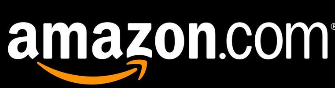

In [3]:
# Download that s##t

path = kagglehub.dataset_download("arhamrumi/amazon-product-reviews")
df = pd.read_csv(os.path.join(path, 'Reviews.csv')) 

df = df.sample(frac=1, random_state=params.random_seed).reset_index(drop=True)[:params.all_data_size]

🔹 Common information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      40000 non-null  int64 
 1   ProductId               40000 non-null  object
 2   UserId                  40000 non-null  object
 3   ProfileName             39997 non-null  object
 4   HelpfulnessNumerator    40000 non-null  int64 
 5   HelpfulnessDenominator  40000 non-null  int64 
 6   Score                   40000 non-null  int64 
 7   Time                    40000 non-null  int64 
 8   Summary                 39998 non-null  object
 9   Text                    40000 non-null  object
dtypes: int64(5), object(5)
memory usage: 3.1+ MB
None

🔍 Nulls:
ProfileName    3
Summary        2
dtype: int64

📊 Data examples:
       Id   ProductId          UserId     ProfileName  HelpfulnessNumerator  \
0   52819  B0050HZLN4  A1ZBPN8BLB409

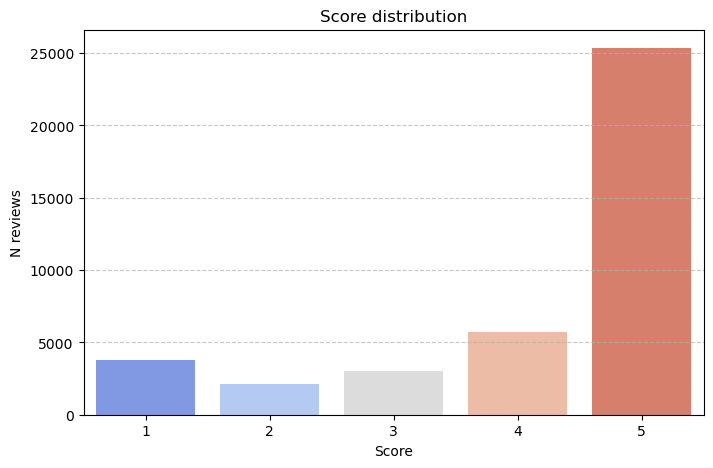

In [4]:
print("🔹 Common information:")
print(df.info())

missing_values = df.isnull().sum()
print("\n🔍 Nulls:")
print(missing_values[missing_values > 0])

print("\n📊 Data examples:")
print(df.head())

df["ProfileName"].fillna("No text", inplace=True)
df["Summary"].fillna("No text", inplace=True)

print("\nNulls after filling:")
null_sum_after_fill = df.isnull().sum()
print(null_sum_after_fill)

assert null_sum_after_fill.sum() == 0

plt.figure(figsize=(8, 5))
sns.countplot(x=df["Score"], palette="coolwarm")
plt.title("Score distribution")
plt.xlabel("Score")
plt.ylabel("N reviews")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## A bit of "feature engineering"

We will use glove-wiki-gigaword-50 embeddings.

Get embeddings of every review, take average and calculate cosine similarity with words 'bad' and 'good' and add 2 new columns 'cos_sim_good' and 'cos_sim_bad'

In [5]:
print("Load embeddings (50-dim)...")
word_vectors = api.load("glove-wiki-gigaword-50")

def get_text_embedding(text, model):
    words = text.lower().split() 
    vectors = [model[word] for word in words if word in model]
    if not vectors:
        return np.zeros(model.vector_size) 
    return np.mean(vectors, axis=0)

def cosine_sim(vec1, vec2):
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]


good_emb = word_vectors["good"]
bad_emb = word_vectors["bad"]

df["cos_sim_good_text"] = df["Text"].apply(lambda x: cosine_sim(get_text_embedding(x, word_vectors), good_emb))
df["cos_sim_bad_text"] = df["Text"].apply(lambda x: cosine_sim(get_text_embedding(x, word_vectors), bad_emb))
df["cos_sim_good_summary"] = df["Summary"].apply(lambda x: cosine_sim(get_text_embedding(x, word_vectors), good_emb))
df["cos_sim_bad_summary"] = df["Summary"].apply(lambda x: cosine_sim(get_text_embedding(x, word_vectors), bad_emb))

print(df[["Text", "Summary", "cos_sim_good_text", "cos_sim_bad_text", "cos_sim_good_summary", "cos_sim_bad_summary"]].head())

df.drop(columns=["Id", "UserId", "ProfileName", "ProductId", "Text", "Summary", 'Time'], inplace=True)

Load embeddings (50-dim)...
                                                Text  \
0  My dog(chihuaha mix) absolutelty loves these. ...   
1  This is a good companion to a french press dev...   
2  I have two young dogs, a dachshund (1yr) and  ...   
3  I would say this mix is pretty comparable to m...   
4  I've never met a combination of dark chocolate...   

                                             Summary  cos_sim_good_text  \
0                                              Chuck           0.885910   
1                   Pretty good medium roast flavor.           0.888065   
2  Dogs love them but ... seems to make them suga...           0.866721   
3                                       Just as good           0.899835   
4        Tasty, ethical...could use more raspberries           0.876732   

   cos_sim_bad_text  cos_sim_good_summary  cos_sim_bad_summary  
0          0.777193              0.349035             0.261557  
1          0.775416              0.850234             

In [ ]:
X = df.drop(columns=["Score"])
y = df["Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=params.random_seed, shuffle=True)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (20000, 6),  Test: (20000, 6)


## Train

In [23]:
param_dict = { 
    'depth': [4,  8],
    'learning_rate': [0.03, 0.3],
    'l2_leaf_reg': [1, 5]
}

model = CatBoostRegressor(loss_function='RMSE', cat_features=[])

grid_search = GridSearchCV(estimator=model, param_grid=param_dict, scoring=None, cv=3, verbose=100, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
y_pred = grid_search.best_estimator_.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

save_dir = './model'

os.makedirs(save_dir, exist_ok=True)

best_model = grid_search.best_estimator_
best_model.save_model(os.path.join(save_dir, 'best_catboost_model.cbm'))

print(f"Model save in {os.path.join(save_dir, 'best_catboost_model.cbm')}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
0:	learn: 1.3218002	total: 4.12ms	remaining: 4.12s
1:	learn: 1.3161092	total: 7.84ms	remaining: 3.91s
2:	learn: 1.3105256	total: 11.7ms	remaining: 3.88s
3:	learn: 1.3057282	total: 15.3ms	remaining: 3.81s
4:	learn: 1.3007355	total: 19ms	remaining: 3.78s
5:	learn: 1.2956021	total: 22.7ms	remaining: 3.75s
6:	learn: 1.2911691	total: 26.3ms	remaining: 3.73s
7:	learn: 1.2860787	total: 30.2ms	remaining: 3.75s
8:	learn: 1.2811842	total: 33.8ms	remaining: 3.73s
9:	learn: 1.2769048	total: 37.8ms	remaining: 3.74s
10:	learn: 1.2727929	total: 42.2ms	remaining: 3.79s
11:	learn: 1.2686279	total: 46.3ms	remaining: 3.81s
12:	learn: 1.2649700	total: 50ms	remaining: 3.8s
13:	learn: 1.2613094	total: 53.8ms	remaining: 3.79s
14:	learn: 1.2573982	total: 57.8ms	remaining: 3.8s
15:	learn: 1.2535281	total: 61.7ms	remaining: 3.79s
16:	learn: 1.2499266	total: 65.4ms	remaining: 3.78s
17:	learn: 1.2467687	total: 68.8ms	remaining: 3.75s
18:	learn: 1.2430279